In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
y1_grid = np.linspace(0, 4, 50)
y2_grid = np.linspace(0, 1, 50)
# mesh grid and construct state space
(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]

In [4]:
π_p = np.array([1, 0, 0])
dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
dΛ2 = γ1 + γ2*y2_mat + π_p@γ3_list*(y2_mat - ȳ)*(y2_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
λ = np.log(2)/6
tol = 1e-7

In [5]:
ems_new = δ*η
ems_old = ems_new
ϵ = 1
episode = 0
lhs_error = 0.5
max_iter = 5_000
while lhs_error > tol:
    if episode ==0:
        v0 =  - y2_mat**2
    else:
        vold = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
    v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    ems_new =  - δ*η/(v0_dy2*λ*θ)
#     ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    print(np.min(ems))
    # HJB coefficient
    A =  -δ*np.ones(y1_mat.shape)
    B_y1 =  y2_mat
    B_y2 = - λ*y2_mat
    C_yy1 = np.zeros(y1_mat.shape)
    C_yy2 = np.zeros(y1_mat.shape)
    D = δ*η*np.log(ems) +  (η-1)*dΛ1*y2_mat - δ*η
    # PDE solver
    solve_start = time.time()
    out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems_old = ems
    print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

0.7515056127811689
Episode 0: PDE Error: 0.238108906203; False Transient Error: 0.188964399019; Iterations: 718; CG Error: 0.000000000100
End of PDE solver, takes time: 0.020149707794189453
0.91920320454367
Episode 1: PDE Error: 0.189031863107; False Transient Error: 0.149751509825; Iterations: 718; CG Error: 0.000000000089
End of PDE solver, takes time: 0.020205974578857422
1.1152481044777363
Episode 2: PDE Error: 0.149817297943; False Transient Error: 0.118450138282; Iterations: 718; CG Error: 0.000000000090
End of PDE solver, takes time: 0.020108938217163086
1.3396558581412261
Episode 3: PDE Error: 0.118513770064; False Transient Error: 0.093491398039; Iterations: 718; CG Error: 0.000000000081
End of PDE solver, takes time: 0.019873380661010742
1.5900884487294848
Episode 4: PDE Error: 0.093552325073; False Transient Error: 0.073614174535; Iterations: 717; CG Error: 0.000000000092
End of PDE solver, takes time: 0.01995229721069336
1.8613421325891533
Episode 5: PDE Error: 0.0736717985

Episode 53: PDE Error: 0.000373689382; False Transient Error: 0.000365031691; Iterations: 696; CG Error: 0.000000000083
End of PDE solver, takes time: 0.020792722702026367
3.423578845507379
Episode 54: PDE Error: 0.000367096890; False Transient Error: 0.000358697954; Iterations: 695; CG Error: 0.000000000100
End of PDE solver, takes time: 0.019270896911621094
3.4195330526116994
Episode 55: PDE Error: 0.000360666383; False Transient Error: 0.000352517802; Iterations: 695; CG Error: 0.000000000098
End of PDE solver, takes time: 0.01946258544921875
3.415642494859183
Episode 56: PDE Error: 0.000354391529; False Transient Error: 0.000346485284; Iterations: 696; CG Error: 0.000000000083
End of PDE solver, takes time: 0.019247055053710938
3.41189593898684
Episode 57: PDE Error: 0.000348266409; False Transient Error: 0.000340594822; Iterations: 694; CG Error: 0.000000000096
End of PDE solver, takes time: 0.019440412521362305
3.4082832554009297
Episode 58: PDE Error: 0.000342285487; False Trans

Episode 97: PDE Error: 0.000189122750; False Transient Error: 0.000187250246; Iterations: 692; CG Error: 0.000000000094
End of PDE solver, takes time: 0.019699811935424805
3.3191892549711164
Episode 98: PDE Error: 0.000186503361; False Transient Error: 0.000184656792; Iterations: 692; CG Error: 0.000000000090
End of PDE solver, takes time: 0.01923847198486328
3.317710616088303
Episode 99: PDE Error: 0.000183925156; False Transient Error: 0.000182104114; Iterations: 692; CG Error: 0.000000000088
End of PDE solver, takes time: 0.019415855407714844
3.3162541952207936
Episode 100: PDE Error: 0.000181387318; False Transient Error: 0.000179591403; Iterations: 692; CG Error: 0.000000000089
End of PDE solver, takes time: 0.019236326217651367
3.3148195192950074
Episode 101: PDE Error: 0.000178889053; False Transient Error: 0.000177117874; Iterations: 692; CG Error: 0.000000000086
End of PDE solver, takes time: 0.019377708435058594
3.3134061359506983
Episode 102: PDE Error: 0.000176429592; False

Episode 141: PDE Error: 0.000104377724; False Transient Error: 0.000103344280; Iterations: 688; CG Error: 0.000000000097
End of PDE solver, takes time: 0.019658803939819336
3.2706396009967325
Episode 142: PDE Error: 0.000103012961; False Transient Error: 0.000101993030; Iterations: 688; CG Error: 0.000000000098
End of PDE solver, takes time: 0.01940774917602539
3.2698451081970905
Episode 143: PDE Error: 0.000101667187; False Transient Error: 0.000100660580; Iterations: 688; CG Error: 0.000000000092
End of PDE solver, takes time: 0.019258737564086914
3.2690613400420054
Episode 144: PDE Error: 0.000100340096; False Transient Error: 0.000099346629; Iterations: 688; CG Error: 0.000000000092
End of PDE solver, takes time: 0.01906895637512207
3.2682881416807676
Episode 145: PDE Error: 0.000099031394; False Transient Error: 0.000098050884; Iterations: 688; CG Error: 0.000000000093
End of PDE solver, takes time: 0.019227027893066406
3.267525360910521
Episode 146: PDE Error: 0.000097740786; Fal

Episode 185: PDE Error: 0.000058918005; False Transient Error: 0.000058334657; Iterations: 684; CG Error: 0.000000000096
End of PDE solver, takes time: 0.019675731658935547
3.2440742689425037
Episode 186: PDE Error: 0.000058162409; False Transient Error: 0.000057586542; Iterations: 684; CG Error: 0.000000000092
End of PDE solver, takes time: 0.019667387008666992
3.2436330722184366
Episode 187: PDE Error: 0.000057416545; False Transient Error: 0.000056848063; Iterations: 684; CG Error: 0.000000000092
End of PDE solver, takes time: 0.019219160079956055
3.2431976538051233
Episode 188: PDE Error: 0.000056680280; False Transient Error: 0.000056119087; Iterations: 684; CG Error: 0.000000000089
End of PDE solver, takes time: 0.018924951553344727
3.242767935295495
Episode 189: PDE Error: 0.000055953481; False Transient Error: 0.000055399485; Iterations: 684; CG Error: 0.000000000088
End of PDE solver, takes time: 0.01914072036743164
3.242343839391356
Episode 190: PDE Error: 0.000055236021; Fal

Episode 229: PDE Error: 0.000033385074; False Transient Error: 0.000033054530; Iterations: 680; CG Error: 0.000000000093
End of PDE solver, takes time: 0.01926136016845703
3.229225611638261
Episode 230: PDE Error: 0.000032956687; False Transient Error: 0.000032630384; Iterations: 680; CG Error: 0.000000000093
End of PDE solver, takes time: 0.019089937210083008
3.228977349099622
Episode 231: PDE Error: 0.000032533799; False Transient Error: 0.000032211682; Iterations: 680; CG Error: 0.000000000094
End of PDE solver, takes time: 0.019080638885498047
3.2287322858247705
Episode 232: PDE Error: 0.000032116339; False Transient Error: 0.000031798355; Iterations: 680; CG Error: 0.000000000096
End of PDE solver, takes time: 0.01886916160583496
3.228490379409919
Episode 233: PDE Error: 0.000031704237; False Transient Error: 0.000031390334; Iterations: 680; CG Error: 0.000000000089
End of PDE solver, takes time: 0.01904606819152832
3.228251588682391
Episode 234: PDE Error: 0.000031297427; False T

Episode 273: PDE Error: 0.000018914156; False Transient Error: 0.000018726886; Iterations: 675; CG Error: 0.000000000098
End of PDE solver, takes time: 0.019388675689697266
3.220840907316061
Episode 274: PDE Error: 0.000018671455; False Transient Error: 0.000018486588; Iterations: 675; CG Error: 0.000000000098
End of PDE solver, takes time: 0.019079923629760742
3.220700206559773
Episode 275: PDE Error: 0.000018431864; False Transient Error: 0.000018249369; Iterations: 675; CG Error: 0.000000000095
End of PDE solver, takes time: 0.018997907638549805
3.2205613021270327
Episode 276: PDE Error: 0.000018195344; False Transient Error: 0.000018015190; Iterations: 675; CG Error: 0.000000000096
End of PDE solver, takes time: 0.018752098083496094
3.2204241713790136
Episode 277: PDE Error: 0.000017961854; False Transient Error: 0.000017784012; Iterations: 675; CG Error: 0.000000000094
End of PDE solver, takes time: 0.01888751983642578
3.2202887913234455
Episode 278: PDE Error: 0.000017731356; Fal

Episode 317: PDE Error: 0.000010712138; False Transient Error: 0.000010606076; Iterations: 670; CG Error: 0.000000000089
End of PDE solver, takes time: 0.01902461051940918
3.2160797435437267
Episode 318: PDE Error: 0.000010574525; False Transient Error: 0.000010469825; Iterations: 670; CG Error: 0.000000000088
End of PDE solver, takes time: 0.018799781799316406
3.2159996855691135
Episode 319: PDE Error: 0.000010438676; False Transient Error: 0.000010335321; Iterations: 670; CG Error: 0.000000000088
End of PDE solver, takes time: 0.018859386444091797
3.2159206446416935
Episode 320: PDE Error: 0.000010304566; False Transient Error: 0.000010202539; Iterations: 670; CG Error: 0.000000000088
End of PDE solver, takes time: 0.018527746200561523
3.215842607769217
Episode 321: PDE Error: 0.000010172175; False Transient Error: 0.000010071463; Iterations: 669; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01877307891845703
3.215765560567352
Episode 322: PDE Error: 0.000010041481; Fals

Episode 361: PDE Error: 0.000011441646; False Transient Error: 0.000006001707; Iterations: 667; CG Error: 0.000000000081
End of PDE solver, takes time: 0.019124269485473633
3.213367547934331
Episode 362: PDE Error: 0.000011499128; False Transient Error: 0.000005924461; Iterations: 666; CG Error: 0.000000000099
End of PDE solver, takes time: 0.018805980682373047
3.2133218867209385
Episode 363: PDE Error: 0.000011555867; False Transient Error: 0.000005848211; Iterations: 666; CG Error: 0.000000000096
End of PDE solver, takes time: 0.018808364868164062
3.2132768046161995
Episode 364: PDE Error: 0.000011611874; False Transient Error: 0.000005772938; Iterations: 666; CG Error: 0.000000000095
End of PDE solver, takes time: 0.018652915954589844
3.213232293903971
Episode 365: PDE Error: 0.000011667160; False Transient Error: 0.000005698630; Iterations: 666; CG Error: 0.000000000092
End of PDE solver, takes time: 0.01885700225830078
3.213188347047647
Episode 366: PDE Error: 0.000011721733; Fals

Episode 405: PDE Error: 0.000013380845; False Transient Error: 0.000003392098; Iterations: 663; CG Error: 0.000000000094
End of PDE solver, takes time: 0.01905989646911621
3.2118197863418163
Episode 406: PDE Error: 0.000013413302; False Transient Error: 0.000003348338; Iterations: 663; CG Error: 0.000000000092
End of PDE solver, takes time: 0.018536090850830078
3.211793714106863
Episode 407: PDE Error: 0.000013445340; False Transient Error: 0.000003305140; Iterations: 663; CG Error: 0.000000000091
End of PDE solver, takes time: 0.01860833168029785
3.2117679716928116
Episode 408: PDE Error: 0.000013476964; False Transient Error: 0.000003262496; Iterations: 663; CG Error: 0.000000000091
End of PDE solver, takes time: 0.01837015151977539
3.211742554909033
Episode 409: PDE Error: 0.000013508179; False Transient Error: 0.000003220401; Iterations: 663; CG Error: 0.000000000089
End of PDE solver, takes time: 0.01864457130432129
3.211717459620322
Episode 410: PDE Error: 0.000013538990; False T

Episode 448: PDE Error: 0.000014456642; False Transient Error: 0.000001939343; Iterations: 661; CG Error: 0.000000000084
End of PDE solver, takes time: 0.018631935119628906
3.2109508254792614
Episode 449: PDE Error: 0.000014475183; False Transient Error: 0.000001914255; Iterations: 660; CG Error: 0.000000000094
End of PDE solver, takes time: 0.01857471466064453
3.2109357345854055
Episode 450: PDE Error: 0.000014493481; False Transient Error: 0.000001889486; Iterations: 660; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0183255672454834
3.210920834852683
Episode 451: PDE Error: 0.000014511544; False Transient Error: 0.000001865036; Iterations: 660; CG Error: 0.000000000091
End of PDE solver, takes time: 0.018516063690185547
3.2109061232554295
Episode 452: PDE Error: 0.000014529373; False Transient Error: 0.000001840901; Iterations: 660; CG Error: 0.000000000092
End of PDE solver, takes time: 0.018284082412719727
3.2108915973369645
Episode 453: PDE Error: 0.000014546972; Fals

Episode 492: PDE Error: 0.000015081297; False Transient Error: 0.000001092456; Iterations: 598; CG Error: 0.000000000096
End of PDE solver, takes time: 0.016912460327148438
3.210435905508976
Episode 493: PDE Error: 0.000015091733; False Transient Error: 0.000001078273; Iterations: 598; CG Error: 0.000000000092
End of PDE solver, takes time: 0.01698613166809082
3.2104282705076383
Episode 494: PDE Error: 0.000015102033; False Transient Error: 0.000001064274; Iterations: 597; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01667475700378418
3.2104209696765693
Episode 495: PDE Error: 0.000015112196; False Transient Error: 0.000001050455; Iterations: 597; CG Error: 0.000000000097
End of PDE solver, takes time: 0.016765594482421875
3.210413763786212
Episode 496: PDE Error: 0.000015122231; False Transient Error: 0.000001036813; Iterations: 597; CG Error: 0.000000000096
End of PDE solver, takes time: 0.016591310501098633
3.210406492083331
Episode 497: PDE Error: 0.000015132135; False

Episode 539: PDE Error: 0.000015449894; False Transient Error: 0.000000590349; Iterations: 592; CG Error: 0.000000000098
End of PDE solver, takes time: 0.01764988899230957
3.210126511827283
Episode 540: PDE Error: 0.000015455527; False Transient Error: 0.000000582649; Iterations: 596; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01744532585144043
3.2101233862359755
Episode 541: PDE Error: 0.000015461087; False Transient Error: 0.000000575049; Iterations: 652; CG Error: 0.000000000089
End of PDE solver, takes time: 0.019065380096435547
3.2101222059345926
Episode 542: PDE Error: 0.000015466574; False Transient Error: 0.000000567549; Iterations: 652; CG Error: 0.000000000087
End of PDE solver, takes time: 0.01882648468017578
3.2101205535568615
Episode 543: PDE Error: 0.000015471988; False Transient Error: 0.000000560148; Iterations: 591; CG Error: 0.000000000091
End of PDE solver, takes time: 0.01742267608642578
3.210117303723329
Episode 544: PDE Error: 0.000015477332; False 

Episode 586: PDE Error: 0.000015648623; False Transient Error: 0.000000318065; Iterations: 649; CG Error: 0.000000000085
End of PDE solver, takes time: 0.018481969833374023
3.209957809000116
Episode 587: PDE Error: 0.000015651655; False Transient Error: 0.000000313895; Iterations: 649; CG Error: 0.000000000087
End of PDE solver, takes time: 0.01903367042541504
3.2099586758629624
Episode 588: PDE Error: 0.000015654646; False Transient Error: 0.000000309781; Iterations: 592; CG Error: 0.000000000096
End of PDE solver, takes time: 0.01663374900817871
3.2099583535697915
Episode 589: PDE Error: 0.000015657598; False Transient Error: 0.000000305715; Iterations: 645; CG Error: 0.000000000089
End of PDE solver, takes time: 0.018561363220214844
3.2099577615992994
Episode 590: PDE Error: 0.000015660513; False Transient Error: 0.000000301707; Iterations: 586; CG Error: 0.000000000099
End of PDE solver, takes time: 0.016531944274902344
3.2099561746749066
Episode 591: PDE Error: 0.000015663389; Fal

Episode 636: PDE Error: 0.000015760217; False Transient Error: 0.000000172200; Iterations: 590; CG Error: 0.000000000097
End of PDE solver, takes time: 0.016745328903198242
3.2098665177084067
Episode 637: PDE Error: 0.000015761777; False Transient Error: 0.000000161918; Iterations: 585; CG Error: 0.000000000100
End of PDE solver, takes time: 0.016577959060668945
3.2098624681543195
Episode 638: PDE Error: 0.000015763323; False Transient Error: 0.000000159788; Iterations: 517; CG Error: 0.000000000094
End of PDE solver, takes time: 0.014526844024658203
3.209857814744515
Episode 639: PDE Error: 0.000015764838; False Transient Error: 0.000000157677; Iterations: 453; CG Error: 0.000000000098
End of PDE solver, takes time: 0.012887954711914062
3.2098547840203846
Episode 640: PDE Error: 0.000015766352; False Transient Error: 0.000000155598; Iterations: 385; CG Error: 0.000000000097
End of PDE solver, takes time: 0.01096343994140625
3.2098539962288957
Episode 641: PDE Error: 0.000015767825; Fa

In [6]:
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

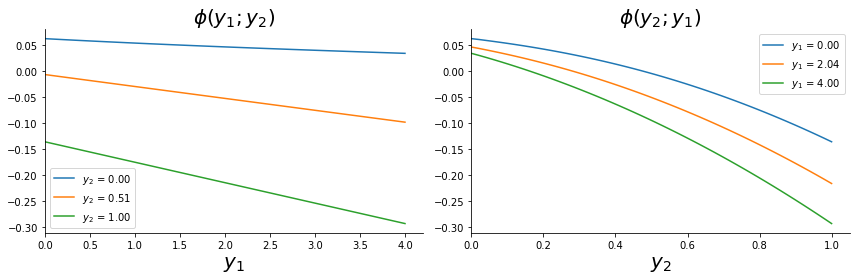

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

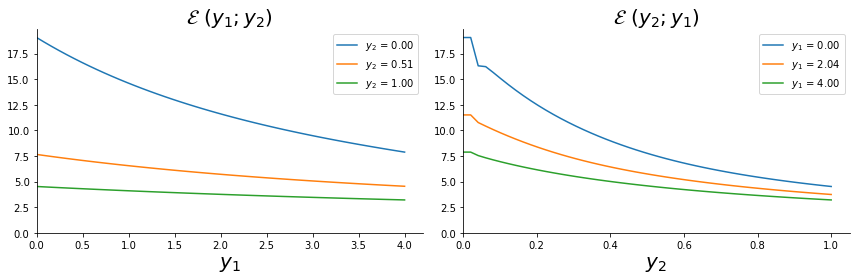

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

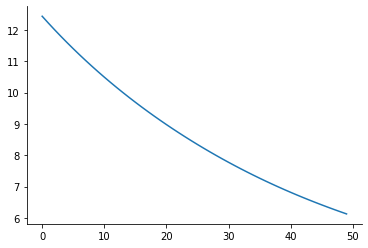

In [9]:
plt.plot(ems[:,10])

In [10]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
    y1 = 1
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [11]:
Y1t,Y2t, Et = simualte_ems(y1_mat, y2_mat, ems, dt=1/4)

In [12]:
ems[13,0], Et[0], Et[6*4]

(14.394666868609265, 12.965003648333195, 6.574921833679188)

In [13]:
Et.shape, np.arange(0,100,1/4).shape

((400,), (400,))

(0.0, 13.362060967028814)

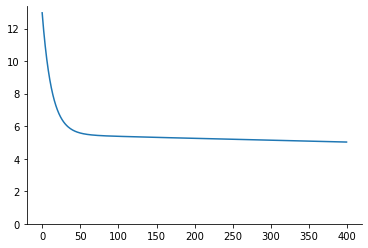

In [14]:
plt.plot(Et)
plt.ylim(0)

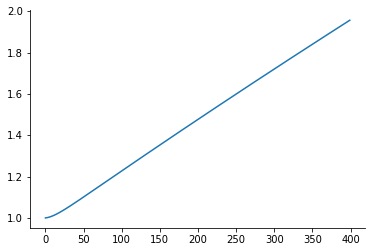

In [15]:
plt.plot(Y1t)

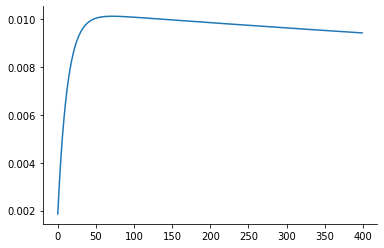

In [16]:
plt.plot(Y2t)

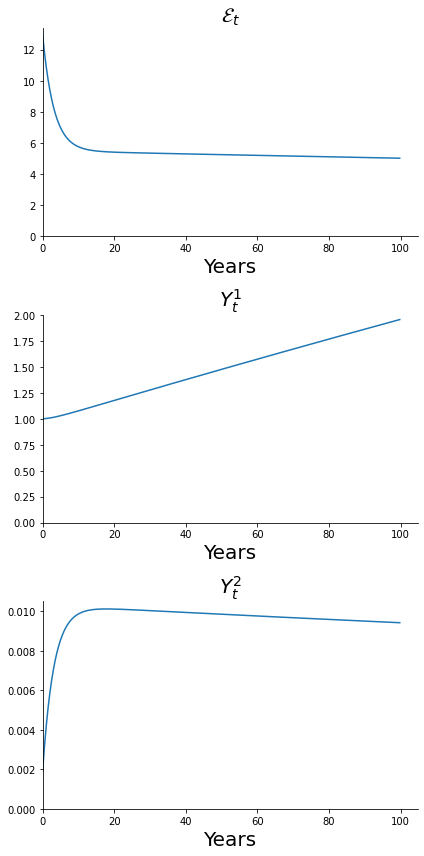

In [17]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")